# 6 Testing whether the statistical power is similar between the situation general (trained on 36 videos) and the situation dependent (trained on 12 videos). 

Randomly select 12 videos from all three situations, run the model to generate prediction score distribtion. Calculate the mean of the distribution, which is a wholebrain map. 


*Yiyu Wang 2023 September*

In [1]:
# time stamp
import time
from datetime import datetime

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import random
import nibabel as nib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# for parallel processing
from joblib import Parallel, delayed, cpu_count
from sklearn.base import BaseEstimator
from sklearn.exceptions import ConvergenceWarning

# stats
from scipy import linalg, ndimage, stats
from scipy.stats import norm

#scikit learn
from sklearn import linear_model
from sklearn.utils import check_random_state
from sklearn.metrics import make_scorer
from sklearn import decomposition

# nifti handling
from nilearn.input_data import NiftiMasker
from nilearn import decoding
import nilearn.masking as masking
from nilearn.masking import apply_mask
from nilearn.image import new_img_like, load_img, get_data, concat_imgs,threshold_img, mean_img

# searchlihgt
from nilearn.input_data.nifti_spheres_masker import _apply_mask_and_get_affinity
from nilearn.image.resampling import coord_transform

# plotting modules
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_img, plot_roi, show

In [3]:
# directories
glm_dir = '/work/abslab/Yiyu/AffVids/fmri_results/model2_OneRegPerVid_VisReg/1stLvl/'
res_dir = '/work/abslab/Yiyu/AffVids/fmri_results/SG12_permutation/'
       
if not os.path.isdir(res_dir):
        os.mkdir(res_dir)
        
# masks:
mask_path ='/work/abslab/Yiyu/AffVids/masks/FSL_binary_MNI152_T1_3mm_brain.nii.gz'
mask = nib.load(mask_path)


#load behavioral data
behavdata_dir =  '/work/abslab/Yiyu/AffVids/BehavData/'

zratings = glob.glob(behavdata_dir +'AffVids_novel_interpolated_rating_zscored.csv')
zratings = pd.read_csv(zratings[0],index_col=0).reset_index()
zratings = zratings.sort_values(by=['sub_id','run']).drop(['index'], axis =1).reset_index(drop=True)


# subjects information
subjects_str = ['04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','23','25','26','28','29'] 
subjects = list(range(4,20))+[23,25,26,28,29]
Nsub = len(subjects)
print("subjects in this analysis:")
print(subjects_str)
print(f"**** n = {Nsub} *****" )


video_list = list(range(1,37))


subjects in this analysis:
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '23', '25', '26', '28', '29']
**** n = 21 *****


Heights


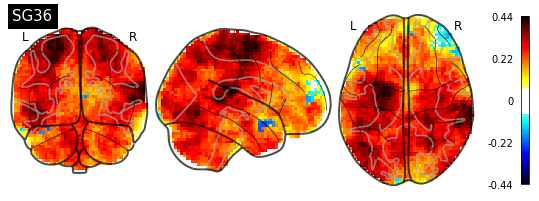

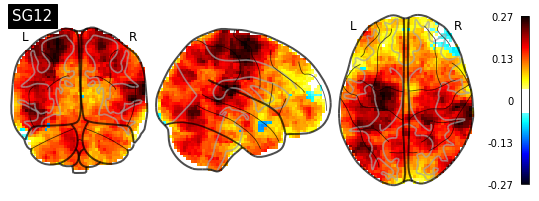

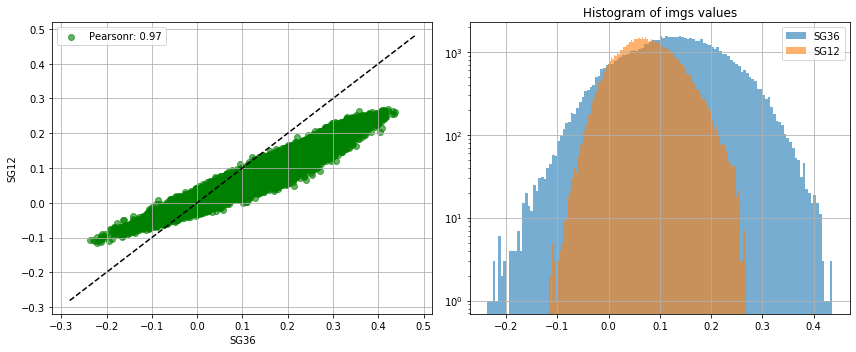

Social


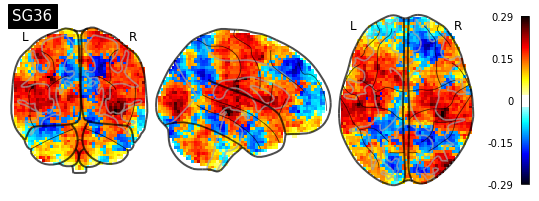

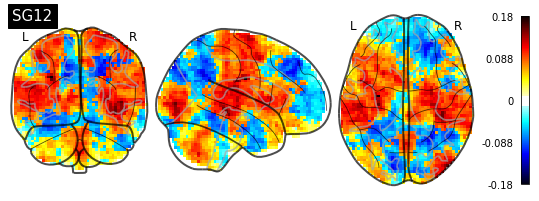

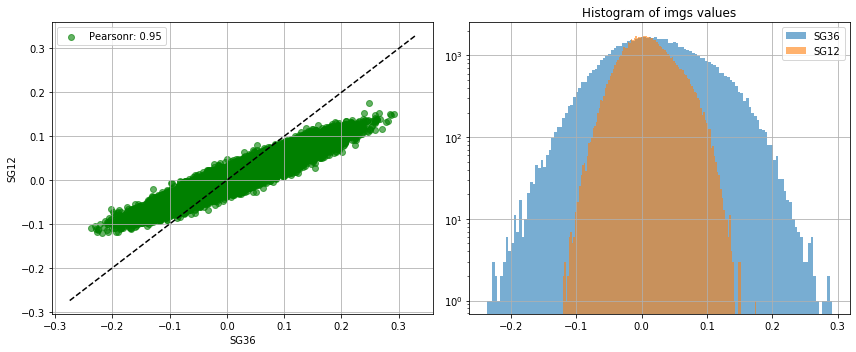

Spiders


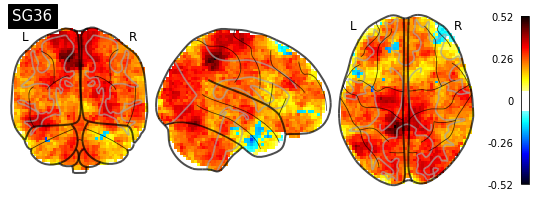

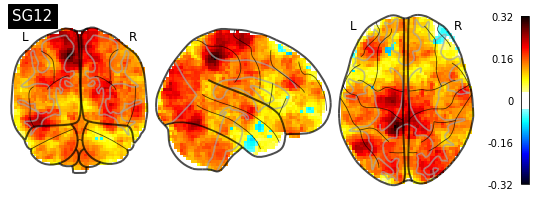

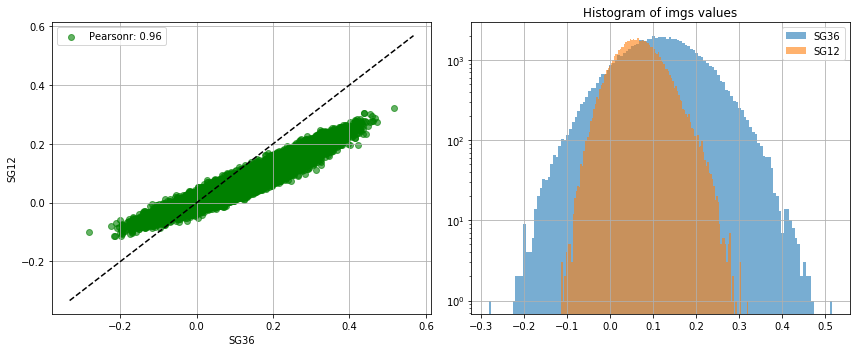

In [5]:
# load the permutation distribution:
save = True
for test_cat in ['Heights','Social','Spiders']:
    if save:
    
        print(test_cat)
        distribution_files = glob.glob(res_dir + f'cv*_kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}_*.nii.gz')
        permut_dist = load_img(distribution_files)
        #save the permutation to one file:
        nib.save(permut_dist, res_dir + f'SG12_permutation_kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}.nii.gz')

    else:
   
        permut_dist = nib.load(res_dir + f'SG12_permutation_kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}.nii.gz')
    
    lasso_file_path = f'/work/abslab/Yiyu/AffVids/fmri_results/searchlight_wholebrain/kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}_avg.nii.gz'     
    SG36_map = nib.load(lasso_file_path)
    SG12_mean_map = mean_img(permut_dist)
    masker = NiftiMasker(mask_img=mask, mask_strategy='epi',standardize=False).fit(SG36_map)

    plotting.plot_glass_brain(
        SG36_map,
        colorbar=True,
        title='SG36',
        plot_abs=False,
        display_mode="ortho",
    )
    plotting.plot_glass_brain(
        SG12_mean_map,
        colorbar=True,
        title='SG12',
        plot_abs=False,
        display_mode="ortho",
    )
    plt.show()

    from nilearn.plotting import plot_img_comparison

    plot_img_comparison(
        [SG36_map], [SG12_mean_map], masker, ref_label="SG36", src_label="SG12"
    )
    plt.show()



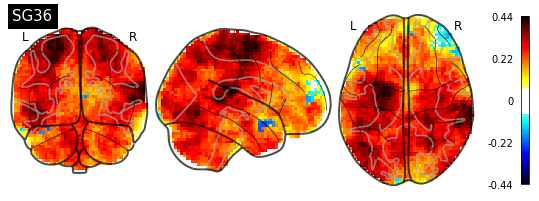

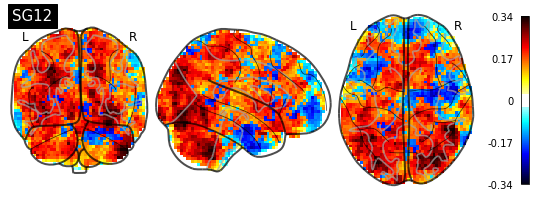

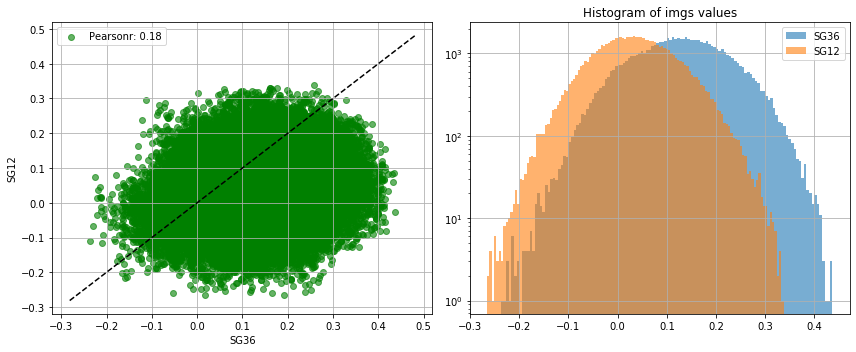

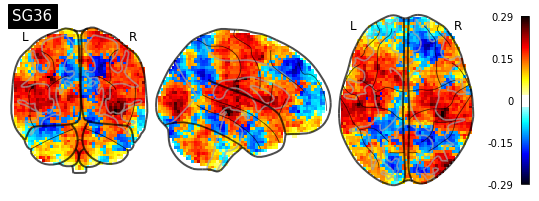

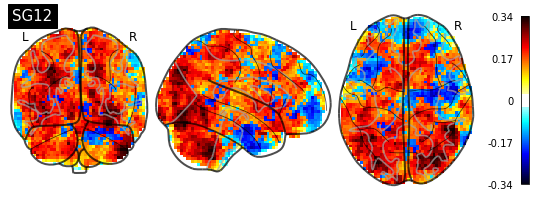

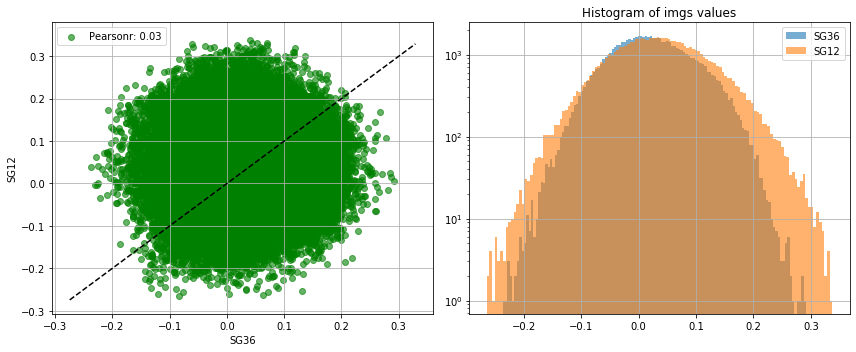

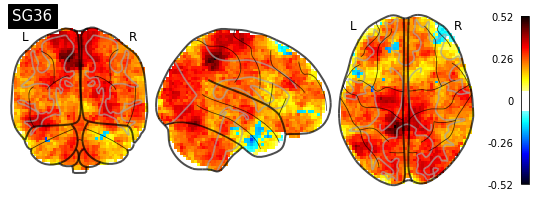

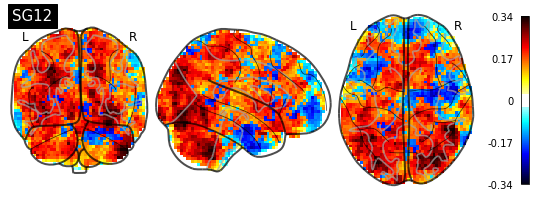

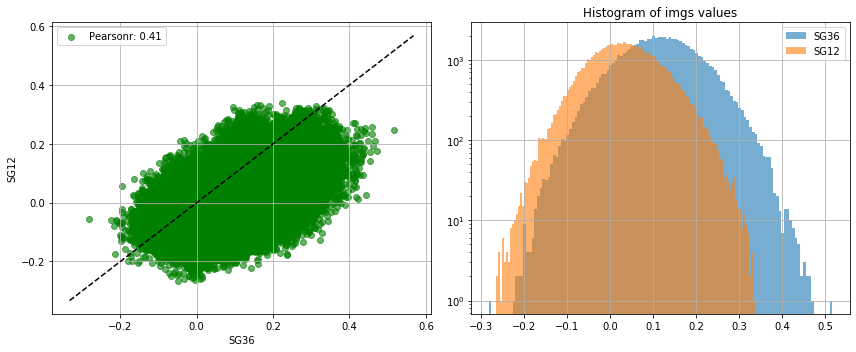

In [13]:
for test_cat in ['Heights','Social','Spiders']:
    lasso_file_path = f'/work/abslab/Yiyu/AffVids/fmri_results/searchlight_wholebrain/kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}_avg.nii.gz'     
    SG36_map = nib.load(lasso_file_path)
    SG12_mean_map = mean_img(distribution_files[15:18])
    masker = NiftiMasker(mask_img=mask, mask_strategy='epi',standardize=False).fit(SG36_map)

    plotting.plot_glass_brain(
        SG36_map,
        colorbar=True,
        title='SG36',
        plot_abs=False,
        display_mode="ortho",
    )
    plotting.plot_glass_brain(
        SG12_mean_map,
        colorbar=True,
        title='SG12',
        plot_abs=False,
        display_mode="ortho",
    )
    plt.show()

    from nilearn.plotting import plot_img_comparison

    plot_img_comparison(
        [SG36_map], [SG12_mean_map], masker, ref_label="SG36", src_label="SG12"
    )
    plt.show()


In [ ]:
# run the same FWE analysis to see if the same regions survived the correction:

save = False
for test_cat in ['Heights','Social','Spiders']:
    if save:
    
        print(test_cat)
        distribution_files = glob.glob(res_dir + f'cv*_kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}_*.nii.gz')
        permut_dist = load_img(distribution_files)
        #save the permutation to one file:
        nib.save(permut_dist, res_dir + f'SG12_permutation_kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}.nii.gz')

    else:
   
        permut_dist = nib.load(res_dir + f'SG12_permutation_kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}.nii.gz')
    
    
    SG12_mean_map = mean_img(permut_dist)
    
    lasso_file_path = f'/work/abslab/Yiyu/AffVids/fmri_results/searchlight_wholebrain/kfold3_searchlight_pearsonr_train_Situation_General_test_{test_cat}_avg.nii.gz'     
    SG36_map = nib.load(lasso_file_path)


